# Comparison of different bias mitigation methods on accuracy and bias metrics

The goal of this analysis is to make a comparison of different bias mitigation methods for classification problems on different types of dataset and to see how these methods impact on different fairness metrics and on the accuracy of the classifier. The datasets on which we will test the fairness algorithms are:

1. Unbias dataset
2. Bias unbalanced dataset
3. Bias balanced dataset

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from numpy.random import default_rng
from collections import OrderedDict
sns.set_theme()

from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover, LFR

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
%matplotlib inline

In [103]:
# utility functions
def compute_dataset_fairness_metrics(data: BinaryLabelDataset, unpriv_group: list, priv_group: list):
    """ Computes: Disparate Impact and Statistical Parity """
    
    b = BinaryLabelDatasetMetric(data, unprivileged_groups=unpriv_group, privileged_groups=priv_group)
    metrics = dict()
    metrics['Disparate Impact'] = b.disparate_impact()
    metrics['Statistical Parity'] = b.statistical_parity_difference()
    for k in metrics:
        print("%s = %.4f" % (k, metrics[k]))
    return metrics

def compute_fairness_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Computes: Balanced Accuracy 
    Statistical Parity Difference
    Disparate Impact
    Average odds difference
    Equal Opportunity Difference
    Theil Index """
    
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

def build_dataset(n_samples, n_features, n_informative, n_sensitive):
    """"Builds a syntetic dataset for classification"""
    x, y = make_classification(n_samples=n_samples, 
                               n_features=n_features, 
                               n_informative=n_informative)
    data = pd.DataFrame(np.column_stack((x,y)), columns=[i for i in range(11)])
    s = np.arange(n_sensitive)
    s = np.repeat(s,n_samples/2)
    rnd = default_rng()
    rnd.shuffle(s)
    data['s'] = s
    return data

def split_data(data: BinaryLabelDataset):
    #data = BinaryLabelDataset(df=data, label_names=label_names, protected_attribute_names=protect_attr_names)
    data_train, data_tv = data.split([0.7], shuffle=True)
    data_test, data_valid = data_tv.split([0.5], shuffle=True)
    return data_train, data_test, data_valid

def x_y_split_dir(train, test):
    x_train = np.delete(train.features, train.feature_names.index('s'), axis=1)
    y_train = train.labels.ravel()
    x_test = np.delete(test.features, test.feature_names.index('s'), axis=1)
    y_test = test.labels.ravel()
    return x_train, y_train, x_test, y_test

def x_y_split(data_train: BinaryLabelDataset, data_test: BinaryLabelDataset):
    X_train = data_train.features
    Y_train = data_train.labels.ravel()
    X_test = data_test.features
    Y_test = data_test.labels.ravel()
    return X_train, Y_train, X_test, Y_test

def compute_classification_metrics(estimator, valid_data):
    
    """"Computes the bias classification metrics 
    in addition to the classification report and a confusion matrix"""
    
    pred = valid_data.copy()
    pred.labels = estimator.predict(pred.features)
    plot_classification_report(classification_report(valid_data.labels, pred.labels))
    plot_confusion_matrix(valid_data.labels, pred.labels, {'1', '0'}, normalize=True)
    class_metrics = compute_fairness_metrics(valid_data, pred, unprivileged_group, privileged_group)
    return class_metrics

In [3]:
# plot functions

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

def plot_metrics_comparison(bias_class_metrics, rw_class_metrics, title1='', title2=''):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    keys = list(bias_class_metrics.keys())
    vals = [float(bias_class_metrics[k]) for k in keys]
    sns.barplot(x=keys, y=vals,ax=ax[0])
    for k in keys:
        ax[0].text(keys.index(k), 
                   bias_class_metrics[k], 
                   round(bias_class_metrics[k], 3), 
                   ha="center",
                   va="bottom",
                   fontsize="medium"
                  )
    keys = list(rw_class_metrics.keys())
    vals = [float(rw_class_metrics[k]) for k in keys]
    sns.barplot(x=keys, y=vals,ax=ax[1])
    for k in keys:
        ax[1].text(keys.index(k), 
                   rw_class_metrics[k], 
                   round(rw_class_metrics[k], 3), 
                   ha="center",
                   va="bottom",
                   fontsize="medium"
                  )
    ax[0].tick_params(labelrotation=90)
    ax[0].set(title=title1)
    ax[1].tick_params(labelrotation=90)
    ax[1].set(title=title2)
    return ax

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1
$$
>Correlation index between the sensitive attribute and the target variable for each individual _i_

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the target variable at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the target variable $y$ are changed s.t. the mean of the $y$ distribution is the mean between the mean of $y$ distribution for the privileged and unprivileged groups. 
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

<!--3. **LFR**

> Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes-->

## Dataset creation

Here we will create a binary labeled dataset with 10.000 samples and 11 features of which 4 are informative features and one will act as sensitive attribute:

In [4]:
n_samples = 10000
n_features = 10
n_informative = 4
n_sensitive = 2

In [5]:
data = build_dataset(n_samples, n_features, n_informative, n_sensitive)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,s
0,-2.934199,0.247402,-1.534495,-0.899855,-0.469156,0.686480,0.338161,-2.980510,0.601419,-0.924379,1.0,0
1,-2.561998,3.954234,-3.728114,-0.870783,0.078019,-0.068890,-0.381607,-3.635413,1.773119,-0.146562,0.0,0
2,-0.375924,-0.546505,1.050957,1.077274,0.623022,0.092158,-1.835276,1.497752,0.254930,-0.569231,1.0,0
3,0.407059,-0.360293,-0.491261,0.458332,-2.107868,0.930491,1.420566,-0.850000,-0.155177,0.441097,1.0,1
4,1.011862,0.547130,-0.999598,0.572229,0.903763,1.077421,1.175023,-0.596162,0.263245,-0.519784,0.0,0


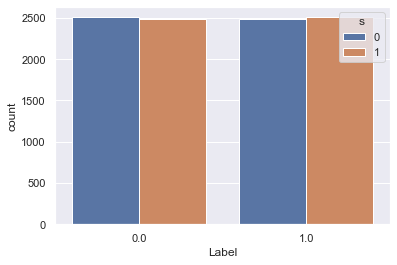

In [6]:
ax = sns.barplot(
    x=10, y='count', 
    hue='s', 
    data=data.groupby('s')[10].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

The dataset seems to be fair with respect to the sensitive attribute

In [7]:
unprivileged_group = [{'s': 0}]
privileged_group = [{'s': 1}]

# Unbias dataset

Here we will apply the metrics and the algorithms defined above on the unbias version of the dataset and compare how these bias mitigation algorithms change the different metrics.

## Dataset fairness metrics 

Let's compute the dataset fairness metrics defined above on the syntetic dataset to check that it is really unbias

In [8]:
bin_data = BinaryLabelDataset(df=data, label_names=[10], protected_attribute_names=['s'])
fair_data_train, fair_data_test, fair_data_valid = split_data(bin_data)
metrics = compute_dataset_fairness_metrics(fair_data_train, unprivileged_group, privileged_group)

Disparate Impact = 1.0103
Statistical Parity = 0.0052


The dataset is not bias.

## Classification bias metrics

Here we train and test a _Logistic Regression_ classifier:

In [9]:
X_train, Y_train, X_test, Y_test = x_y_split(fair_data_train, fair_data_test)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe_fit = pipe.fit(X_train, Y_train, logisticregression__sample_weight=fair_data_train.instance_weights.ravel())
score = cross_val_score(pipe_fit, X_test, Y_test)
print("Accuracy: %f"% np.mean(score))

Accuracy: 0.880667


Balanced accuracy = 0.8719
Statistical parity difference = -0.0000
Disparate impact = 0.9999
Average odds difference = 0.0063
Equal opportunity difference = 0.0167
Theil index = 0.0882


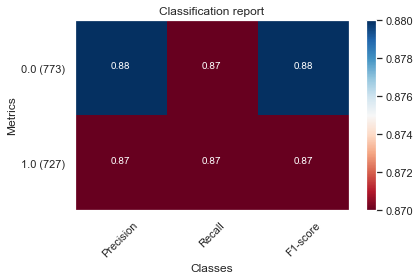

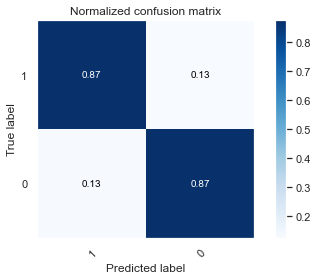

In [10]:
class_metrics = compute_classification_metrics(pipe_fit, fair_data_valid)
plt.show()

From the values of the metrics we can see that the classifier is fair and quite accurate. Let's now test the same metrics on a bias dataset.

## Reweighing

Here we apply the _Reweighing_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [11]:
rw_unbias_data = bin_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_unbias_data = rw.fit_transform(rw_unbias_data)

### Dataset metrics

In [12]:
metrics = compute_dataset_fairness_metrics(rw_unbias_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

In [13]:
rw_un_train, rw_un_test, rw_un_valid = split_data(rw_unbias_data)
x_train, y_train, x_test, y_test = x_y_split(rw_un_train, rw_un_test)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe = pipe.fit(x_train, y_train, logisticregression__sample_weight=rw_un_train.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, fit_params={"logisticregression__sample_weight": rw_un_test.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.869333


Balanced accuracy = 0.8865
Statistical parity difference = 0.0320
Disparate impact = 1.0688
Average odds difference = 0.0217
Equal opportunity difference = 0.0394
Theil index = 0.0806


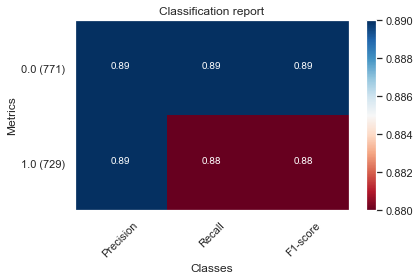

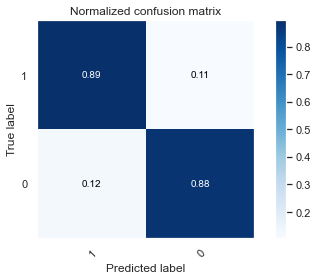

In [14]:
#rw_un_valid.features = np.delete(rw_un_valid.features, rw_un_valid.feature_names.index('s'), axis=1)
rw_un_metrics = compute_classification_metrics(pipe, rw_un_valid)
plt.show()

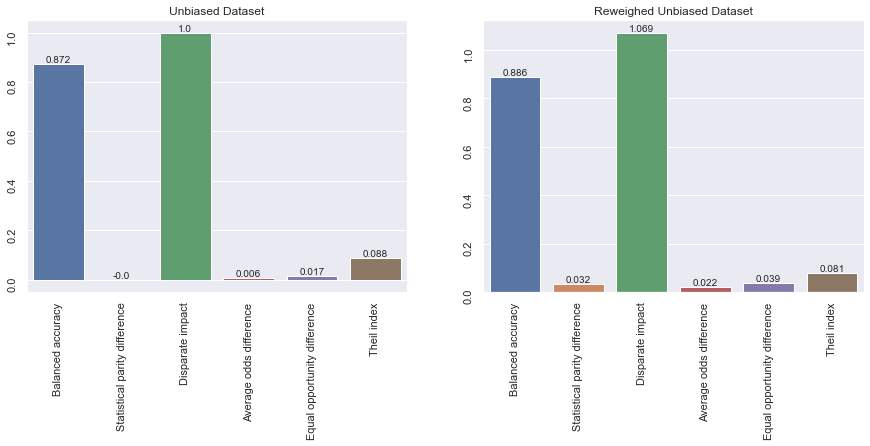

In [15]:
plot_metrics_comparison(class_metrics, rw_un_metrics, "Unbiased Dataset", "Reweighed Unbiased Dataset")
plt.show()

## Disparate Impact Remover

Here we apply the _Disparate Impact Remover_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [16]:
dir_unb_data = bin_data.copy()
scaler = MinMaxScaler(copy=False)
dir_unb_data.features = scaler.fit_transform(dir_unb_data.features)

In [17]:
di = DisparateImpactRemover(sensitive_attribute='s')
dir_unb_data = di.fit_transform(dir_unb_data)

### Dataset metrics

In [18]:
metrics = compute_dataset_fairness_metrics(dir_unb_data, unprivileged_group, privileged_group)

Disparate Impact = 0.9936
Statistical Parity = -0.0032


### Classification metrics

In [65]:
train_dir_un, test_dir_un, valid_dir_un = split_data(dir_unb_data)
#x_train, y_train, x_test, y_test = x_y_split(train_dir_un, test_dir_un)
x_train = np.delete(train_dir_un.features, train_dir_un.feature_names.index('s'), axis=1)
y_train = train_dir_un.labels.ravel()
x_test = np.delete(test_dir_un.features, test_dir_un.feature_names.index('s'), axis=1)
y_test = test_dir_un.labels.ravel()
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe = pipe.fit(x_train, y_train, logisticregression__sample_weight=train_dir_un.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, fit_params={"logisticregression__sample_weight": test_dir_un.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.884667


Balanced accuracy = 0.8771
Statistical parity difference = -0.0067
Disparate impact = 0.9867
Average odds difference = 0.0030
Equal opportunity difference = 0.0106
Theil index = 0.0925


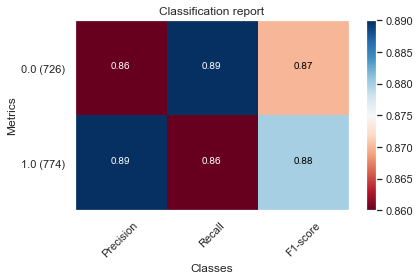

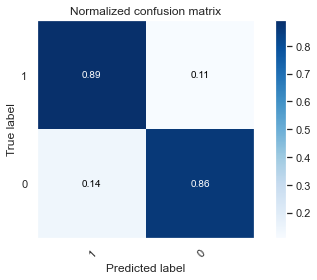

In [66]:
valid_dir_un.features = np.delete(valid_dir_un.features, valid_dir_un.feature_names.index('s'), axis=1)
dir_fair_metrics = compute_classification_metrics(pipe, valid_dir_un)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


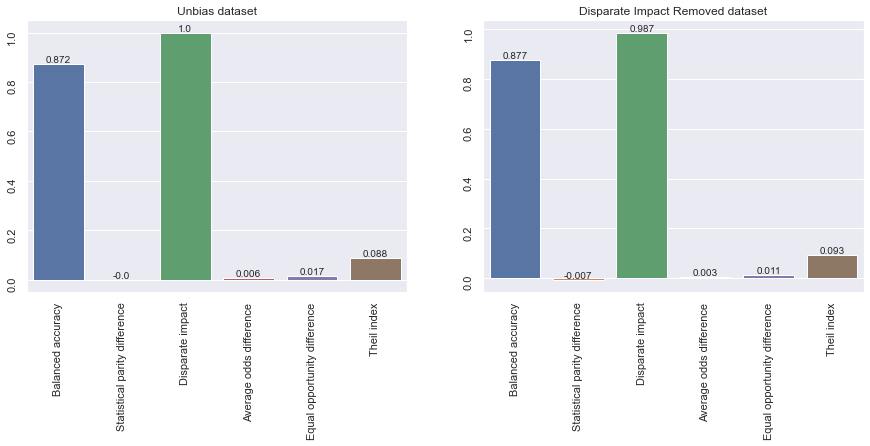

In [67]:
plot_metrics_comparison(class_metrics, dir_fair_metrics, "Unbias dataset", "Disparate Impact Removed dataset")
plt.show()

## Reweighing vs Disparate Impact Remover

In the following we compare the performances of _Reweighing_ and _Disparate Impact Remover_ on the unbias dataset. 

In [68]:
merged_metrics = pd.DataFrame(class_metrics, index=[0])
merged_metrics = merged_metrics.append(rw_un_metrics, ignore_index=True)
merged_metrics = merged_metrics.append(dir_fair_metrics, ignore_index=True)
merged_metrics.loc[0,'Dataset'] = 'Unbias Data'
merged_metrics.loc[1,'Dataset'] = 'Reweighed'
merged_metrics.loc[2,'Dataset'] = 'Disparate Impact Removed'
merged_metrics = merged_metrics.melt(id_vars='Dataset', value_name='values', var_name='metrics')

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


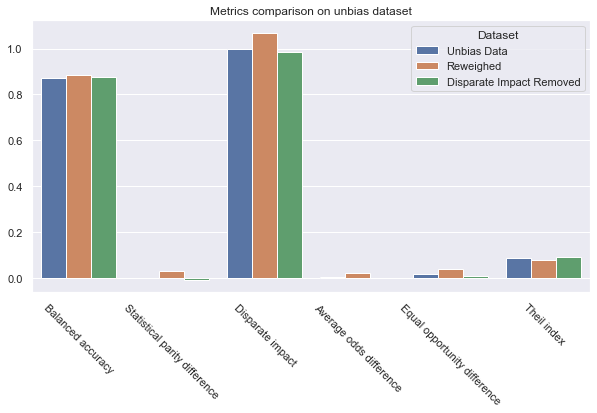

In [69]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(data = merged_metrics, x='metrics', y='values', hue='Dataset', ax=ax)
plt.xticks(rotation=-45)
plt.ylabel(ylabel='')
plt.xlabel(xlabel='')
plt.title('Metrics comparison on unbias dataset')
plt.show()

# Unbalanced Bias dataset

Let's change the previous dataset adding a bias on the sensitive attribute `s` with value 0 and keeping the instances with `s=1` invariate:

In [24]:
bias_data = data.copy()
bias_data.loc[(bias_data['s'] == 0) & (bias_data.index < int(n_samples/2)) , 10] = 0.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


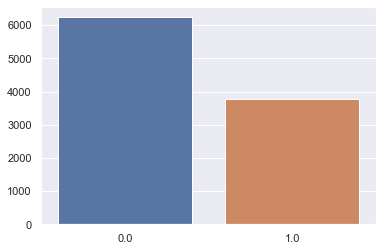

In [25]:
sns.barplot(x=bias_data[10].value_counts().index, y=bias_data[10].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


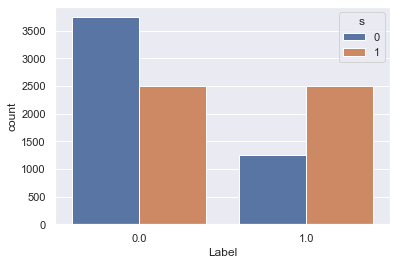

In [26]:
ax = sns.barplot(
    x=10, y='count', 
    hue='s', 
    data=bias_data.groupby('s')[10].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

## Dataset fairness metrics

Let's compute the dataset fairness metrics on this new dataset:

In [56]:
bias_data_bin = BinaryLabelDataset(df = bias_data, label_names=[10], protected_attribute_names=['s'])
bias_metrics = compute_dataset_fairness_metrics(bias_data_bin, unprivileged_group, privileged_group)

Disparate Impact = 0.5006
Statistical Parity = -0.2504


## Classification bias metrics

In [57]:
bias_train, bias_test, bias_valid = split_data(bias_data_bin)

In [28]:
x_train, y_train, x_test, y_test = x_y_split(bias_train, bias_test)
bias_pipe = make_pipeline(StandardScaler(), LogisticRegression())
bias_pipe_fit = bias_pipe.fit(
    x_train, y_train, logisticregression__sample_weight=bias_train.instance_weights.ravel())
bias_accuracy = cross_val_score(bias_pipe_fit, x_test, y_test)
print("Accuracy: %f" % np.mean(bias_accuracy))

Accuracy: 0.784000


Balanced accuracy = 0.8077
Statistical parity difference = -0.3327
Disparate impact = 0.3262
Average odds difference = -0.2687
Equal opportunity difference = -0.5507
Theil index = 0.1318


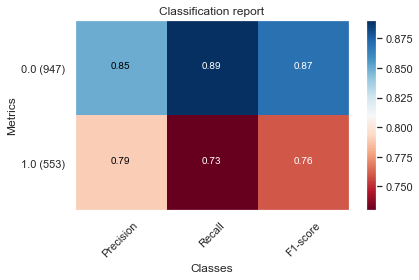

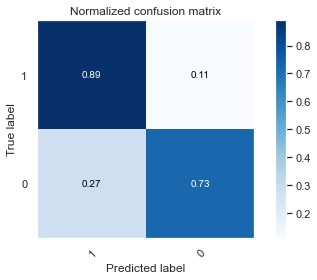

In [29]:
bias_class_metrics = compute_classification_metrics(bias_pipe_fit, bias_valid)

##  Reweighing

In [30]:
rw_data = bias_data_bin.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_data = rw.fit_transform(rw_data)
print(rw_data.instance_weights)

[0.83284379 0.83284379 0.83284379 ... 0.83284379 0.75029916 1.49880478]


### Dataset metrics

In [31]:
rw_metrics = compute_dataset_fairness_metrics(rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = -0.0000


### Classification metrics

In [32]:
rw_train, rw_test, rw_valid = split_data(rw_data)
x_train, y_train, x_test, y_test = x_y_split(rw_train, rw_test)

In [33]:
rw_pipeline = make_pipeline(StandardScaler(), LogisticRegression())
rw_pipeline.fit(x_train, y_train, logisticregression__sample_weight=rw_train.instance_weights.ravel())
score = cross_val_score(
    rw_pipeline, x_test, y_test, 
    fit_params={"logisticregression__sample_weight": rw_test.instance_weights.ravel()}
)
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.782000


Balanced accuracy = 0.7751
Statistical parity difference = 0.0532
Disparate impact = 1.1638
Average odds difference = 0.0008
Equal opportunity difference = -0.1553
Theil index = 0.1399


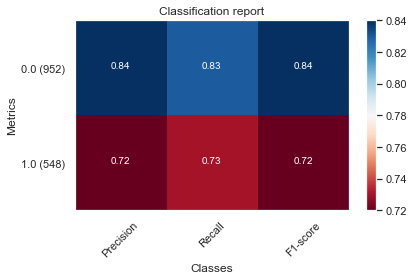

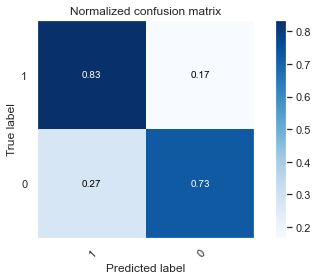

In [34]:
#rw_valid.features = np.delete(rw_valid.features, rw_valid.feature_names.index('s'), axis=1)
rw_class_metrics = compute_classification_metrics(rw_pipeline, rw_valid)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


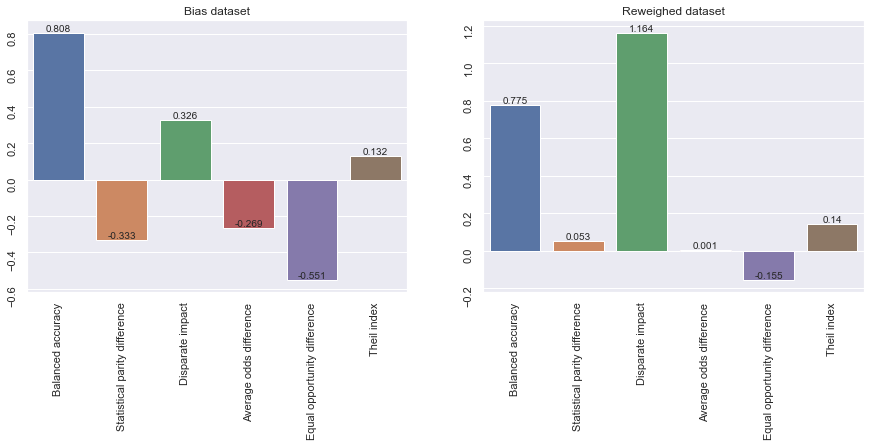

In [35]:
plot_metrics_comparison(bias_class_metrics, rw_class_metrics, "Bias dataset", "Reweighed dataset")
plt.show()

## Disparate Impact Remover

In [36]:
dir_data = bias_data_bin.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

In [37]:
dr = DisparateImpactRemover(sensitive_attribute='s')
dir_data = dr.fit_transform(dir_data)

### Dataset metrics

In [38]:
dir_metrics = compute_dataset_fairness_metrics(dir_data, unprivileged_group, privileged_group)

Disparate Impact = 0.5006
Statistical Parity = -0.2504


### Classification metrics

In [39]:
dir_train, dir_test, dir_valid = split_data(dir_data)

In [40]:
x_train = np.delete(dir_train.features, dir_train.feature_names.index('s'), axis=1)
y_train = dir_train.labels.ravel()
x_test = np.delete(dir_test.features, dir_test.feature_names.index('s'), axis=1)
y_test = dir_test.labels.ravel()

In [41]:
dr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
dr_pipe.fit(x_train, y_train)
score = cross_val_score(dr_pipe, x_test, y_test)
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.777333


Balanced accuracy = 0.7416
Statistical parity difference = 0.0470
Disparate impact = 1.1466
Average odds difference = 0.1413
Equal opportunity difference = 0.0726
Theil index = 0.1770


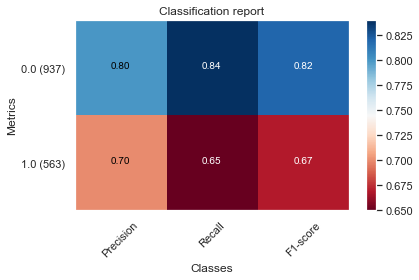

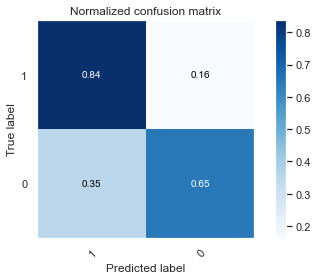

In [42]:
dir_valid_final = dir_valid.copy()
dir_valid_final.features = np.delete(dir_valid.features, dir_valid.feature_names.index('s'), axis=1)
dir_class_metrics = compute_classification_metrics(dr_pipe, dir_valid_final)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


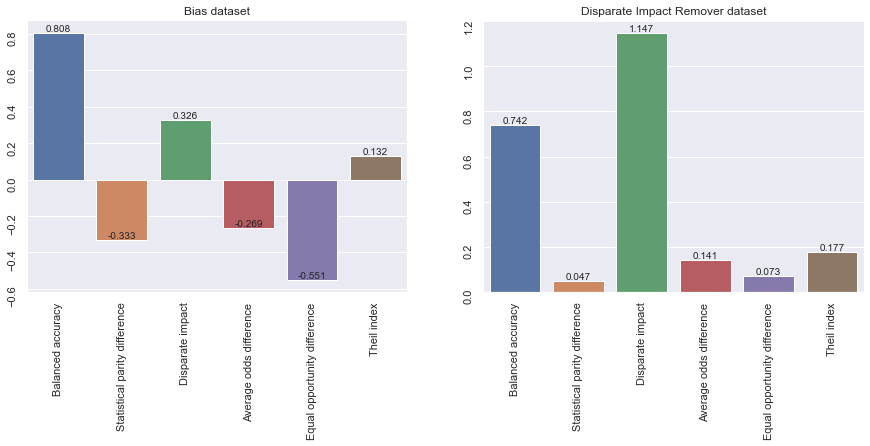

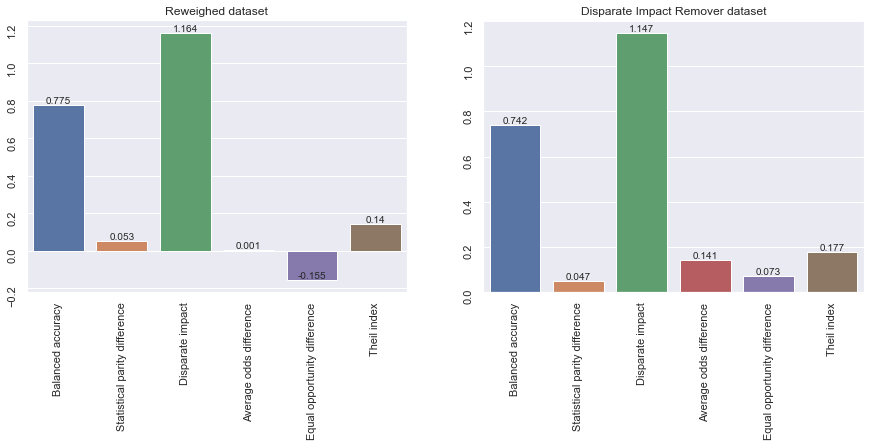

In [43]:
plot_metrics_comparison(bias_class_metrics, dir_class_metrics, "Bias dataset", "Disparate Impact Remover dataset")
plot_metrics_comparison(rw_class_metrics, dir_class_metrics, "Reweighed dataset", "Disparate Impact Remover dataset")
plt.show()

## Reweighing vs Disparate Impact Remover

In [44]:
merged_metrics = pd.DataFrame(bias_class_metrics, index=[0])
merged_metrics = merged_metrics.append(rw_class_metrics, ignore_index=True)
merged_metrics = merged_metrics.append(dir_class_metrics, ignore_index=True)
merged_metrics.loc[0,'Dataset'] = 'Bias unbalanced Data'
merged_metrics.loc[1,'Dataset'] = 'Reweighed'
merged_metrics.loc[2,'Dataset'] = 'Disparate Impact Removed'
merged_metrics = merged_metrics.melt(id_vars='Dataset', value_name='values', var_name='metrics')

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


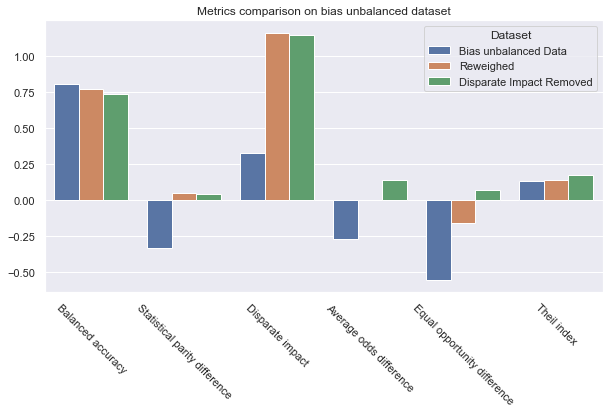

In [45]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(data = merged_metrics, x='metrics', y='values', hue='Dataset', ax=ax)
plt.xticks(rotation=-45)
plt.ylabel(ylabel='')
plt.xlabel(xlabel='')
plt.title('Metrics comparison on bias unbalanced dataset')
plt.show()

# Bias balanced dataset

In [82]:
bias_bal_data = bias_data.copy()
bias_bal_data.loc[(bias_data['s'] == 1) & (bias_data.index < int(n_samples/2)) , 10] = 1.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


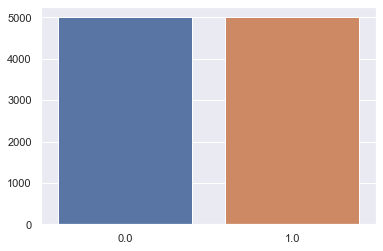

In [83]:
sns.barplot(x=bias_bal_data[10].value_counts().index, y=bias_bal_data[10].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


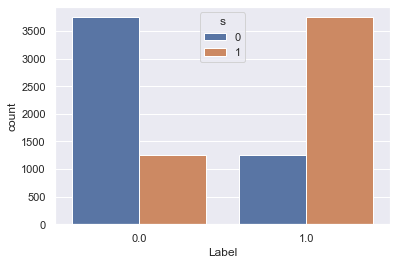

In [84]:
ax = sns.barplot(
    x=10, y='count', 
    hue='s', 
    data=bias_bal_data.groupby('s')[10].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

In [85]:
bias_bal_bin = BinaryLabelDataset(df=bias_bal_data, label_names=[10], protected_attribute_names=['s'])

## Dataset metrics

In [86]:
bal_metrics = compute_dataset_fairness_metrics(bias_bal_bin, unprivileged_group, privileged_group)

Disparate Impact = 0.3348
Statistical Parity = -0.4986


## Classification metrics

In [87]:
train, test, valid = split_data(bias_bal_bin)

In [88]:
x_train, y_train, x_test, y_test = x_y_split(train, test)

In [89]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train)
score = cross_val_score(pipe, x_test, y_test)
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.733333


Balanced accuracy = 0.7530
Statistical parity difference = -0.7636
Disparate impact = 0.1559
Average odds difference = -0.6913
Equal opportunity difference = -0.6521
Theil index = 0.1628


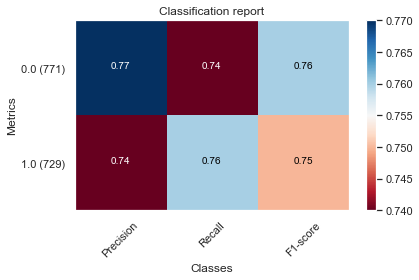

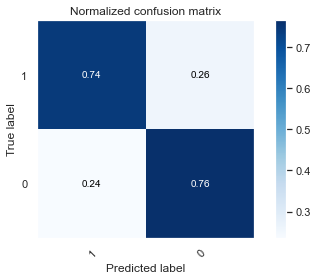

In [90]:
bias_bal_metrics = compute_classification_metrics(pipe, valid)

## Reweighing

In [91]:
rw_bal = bias_bal_bin.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_bal = rw.fit_transform(rw_bal)

In [92]:
rw_bal.instance_weights

array([0.66715621, 0.66715621, 0.66715621, ..., 0.66715621, 0.66742263,
       1.99322709])

### Dataset metrics

In [93]:
rw_metrics = compute_dataset_fairness_metrics(rw_bal, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

In [94]:
rw_train, rw_test, rw_valid = split_data(rw_bal)

In [95]:
x_train, y_train, x_test, y_test = x_y_split(rw_train, rw_test)

In [96]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train, logisticregression__sample_weight=rw_train.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, 
                        fit_params={"logisticregression__sample_weight": rw_test.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.712000


Balanced accuracy = 0.7428
Statistical parity difference = 0.0731
Disparate impact = 1.1714
Average odds difference = 0.0954
Equal opportunity difference = 0.0860
Theil index = 0.2164


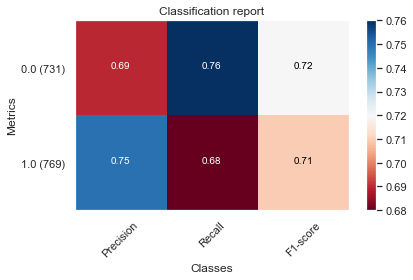

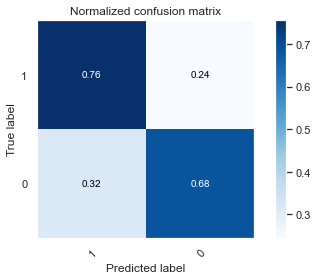

In [97]:
rw_metrics = compute_classification_metrics(pipe, rw_valid)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


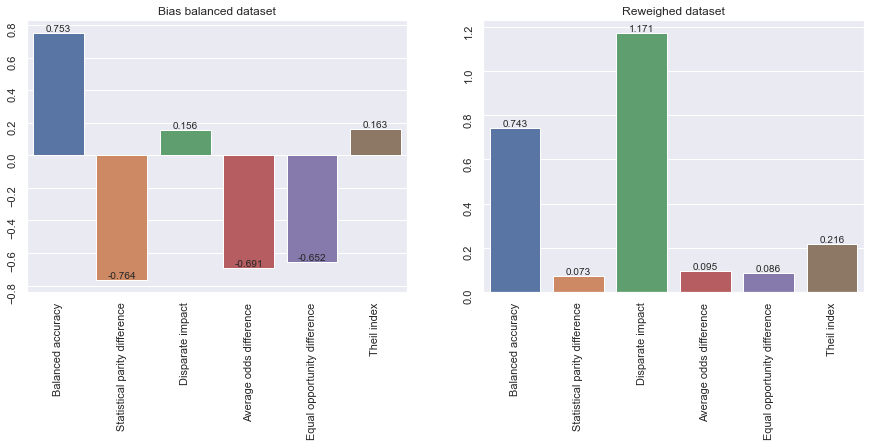

In [98]:
plot_metrics_comparison(bias_bal_metrics, rw_metrics, 'Bias balanced dataset', 'Reweighed dataset')
plt.show()

## Disparate Impact Remover

In [105]:
dir_bal = bias_bal_bin.copy()
scaler = MinMaxScaler()
dir_bal.features = scaler.fit_transform(dir_bal.features)
dr = DisparateImpactRemover(sensitive_attribute='s')
dir_bal = dr.fit_transform(dir_bal)

### Dataset metrics

In [106]:
dir_metrics = compute_dataset_fairness_metrics(dir_bal, unprivileged_group, privileged_group)

Disparate Impact = 0.3348
Statistical Parity = -0.4986


### Classification metrics

In [107]:
train, test, valid = split_data(dir_bal)

In [108]:
x_train, y_train, x_test, y_test = x_y_split_dir(train, test)

In [109]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train)
score = cross_val_score(pipe, x_test, y_test)
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.686667


Balanced accuracy = 0.6780
Statistical parity difference = 0.0440
Disparate impact = 1.0918
Average odds difference = 0.2743
Equal opportunity difference = 0.2945
Theil index = 0.2250


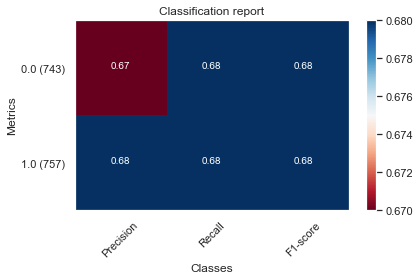

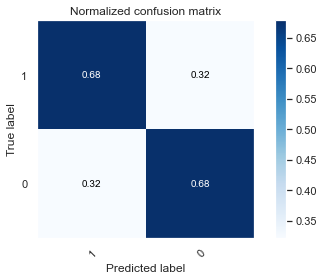

In [110]:
valid_copy = valid.copy()
valid_copy.features = np.delete(valid.features, valid.feature_names.index('s'), axis=1)
dir_score = compute_classification_metrics(pipe, valid_copy)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


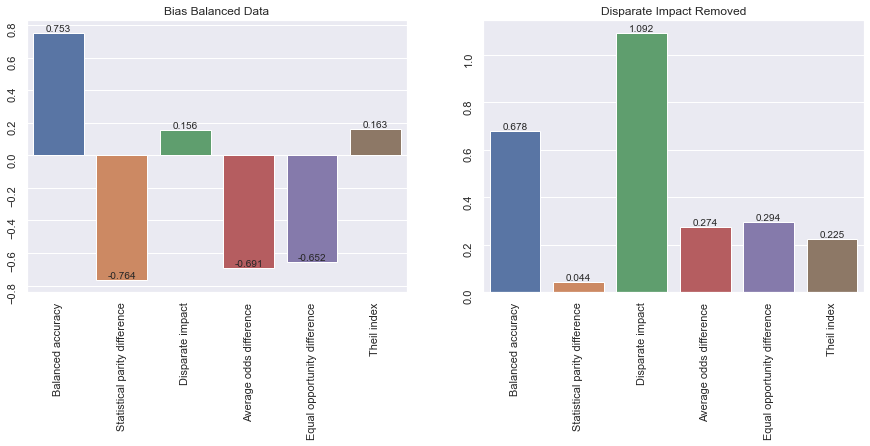

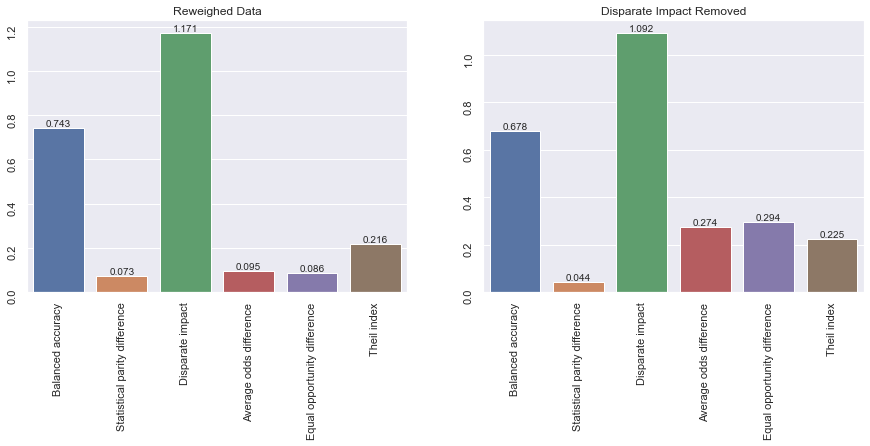

In [113]:
plot_metrics_comparison(bias_bal_metrics, dir_score, 'Bias Balanced Data', 'Disparate Impact Removed')
plot_metrics_comparison(rw_metrics, dir_score, 'Reweighed Data', 'Disparate Impact Removed')
plt.show()

In [114]:
merged_metrics = pd.DataFrame(bias_bal_metrics, index=[0])
merged_metrics = merged_metrics.append(rw_metrics, ignore_index=True)
merged_metrics = merged_metrics.append(dir_score, ignore_index=True)
merged_metrics.loc[0,'Dataset'] = 'Bias Balanced Data'
merged_metrics.loc[1,'Dataset'] = 'Reweighed'
merged_metrics.loc[2,'Dataset'] = 'Disparate Impact Removed'
merged_metrics = merged_metrics.melt(id_vars='Dataset', value_name='values', var_name='metrics')

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


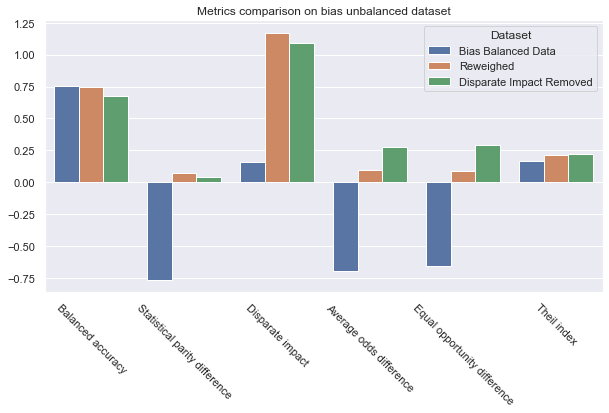

In [115]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(data = merged_metrics, x='metrics', y='values', hue='Dataset', ax=ax)
plt.xticks(rotation=-45)
plt.ylabel(ylabel='')
plt.xlabel(xlabel='')
plt.title('Metrics comparison on bias unbalanced dataset')
plt.show()